### Libraries import and simple setup

In [2]:
library(openxlsx)
library(ggplot2)
library(dplyr)
library(cowplot)
library(latex2exp)

In [3]:
theme_set(theme_bw()) # theme setup
opt.dpi = 1000 # plots export resolution *.tiff

### 1. Importing and adjusting fermentation data

In [4]:
df.fer <- read.xlsx("../data/data.xlsx",sheet='fermentation')

# adjusting data, creating factors, adjusting data types, etc.
df.fer$`Volume.[Nml]` <- as.numeric(df.fer$`Volume.[Nml]`) # some text artifacts are present so as.numeric has to be used
df.fer$`disintegration.temp.[oC]` <- factor(df.fer$`disintegration.temp.[oC]`,
                                            ordered=TRUE, levels=c('in.','b.d.','45','50','55','60'))
df.fer$`disintegration.time.[h]` <- factor(df.fer$`disintegration.time.[h]`,
                                           ordered=TRUE,levels=c('in.','0','24','48'))

# creating new factor to distinguish between case No and experiment included in a case
df.fer$case.exp <- factor(paste(df.fer$case.No, df.fer$experiment.No,sep='-'))


# changing the column names for simpler manipulation
df.fer.original.col.names <- colnames(df.fer) # just in case
df.fer.simlified.col.names <- c('day','volume','original.column.header','description','composition','inoculum.weight',
                                'co-substrate.weight','dis.temp','dis.time','case','experiment','disintegration.tab','case.exp')

colnames(df.fer) <- df.fer.simlified.col.names

# removing one series - it turned out to be invalid
bad.series_case.exp <- '35-1' # it will be removed in some analyses
df.fer <- df.fer[df.fer$case.exp != bad.series_case.exp,]

#### 1.1. Adjusting the factor naming
Replacing the original labels with new clearer labels
##### 1.1.1. Sample type labels

In [5]:
df.fer$sample.type <- paste(df.fer$dis.temp,df.fer$dis.time,sep="/")
                             
#manually
fact.old <- c('in./in.','b.d./0', '45/24', '45/48', '50/24', '50/48', '55/24', '55/48', '60/24', '60/48')
fact.new <- c('INC','INC+WAS', 'INC+45/24WAS', 'INC+45/48WAS', 'INC+50/24WAS', 'INC+50/48WAS', 'INC+55/24WAS', 
              'INC+55/48WAS', 'INC+60/24WAS', 'INC+60/48WAS')
                             
for (ixf in 1:length(fact.old)){
    df.fer[df.fer$sample.type == fact.old[ixf],'sample.type'] <- fact.new[ixf]
}

df.fer$sample.type <- factor(df.fer$sample.type,ordered=TRUE, levels=fact.new)

##### 1.1.2. Processing temperature labels

In [6]:
fact.temp.old <- c('in.','b.d.','45','50','55','60')
fact.temp.new <- c('INC','INC+WAS','T=45°C','T=50°C','T=55°C','T=60°C')
df.fer$dis.temp.new <- rep(NA,nrow(df.fer))
for (ixf in 1:length(fact.temp.old)){
    df.fer[df.fer$dis.temp == fact.temp.old[ixf],'dis.temp.new'] <- fact.temp.new[ixf]
}
df.fer$dis.temp.new <- factor(df.fer$dis.temp.new,ordered = TRUE,levels=fact.temp.new)

##### 1.1.3. Pretreatment time labels

In [7]:
fact.time.old <- c('in.','0','24','48')
fact.time.new <- c('INC','INC+WAS','t=24h','t=48h')
df.fer$dis.time.new <- rep(NA,nrow(df.fer))
for (ixf in 1:length(fact.time.old)){
    df.fer[df.fer$dis.time == fact.time.old[ixf],'dis.time.new'] <- fact.time.new[ixf]
}
df.fer$dis.time.new <- factor(df.fer$dis.time.new,ordered = TRUE,levels = fact.time.new)
head(df.fer)

,day,volume,original.column.header,description,composition,inoculum.weight,co-substrate.weight,dis.temp,dis.time,case,experiment,disintegration.tab,case.exp,sample.type,dis.temp.new,dis.time.new
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<ord>,<ord>,<dbl>,<dbl>,<chr>,<fct>,<ord>,<ord>,<ord>
1,0,0.0,F.S(317.8g) Volume [Nml],inoculum only,F.S.+water,317.8,NA,in.,in.,30,1,NA,30-1,INC,INC,INC
2,1,154.5,F.S(317.8g) Volume [Nml],inoculum only,F.S.+water,317.8,NA,in.,in.,30,1,NA,30-1,INC,INC,INC
3,2,212.5,F.S(317.8g) Volume [Nml],inoculum only,F.S.+water,317.8,NA,in.,in.,30,1,NA,30-1,INC,INC,INC
4,3,246.4,F.S(317.8g) Volume [Nml],inoculum only,F.S.+water,317.8,NA,in.,in.,30,1,NA,30-1,INC,INC,INC
5,4,269.0,F.S(317.8g) Volume [Nml],inoculum only,F.S.+water,317.8,NA,in.,in.,30,1,NA,30-1,INC,INC,INC
6,5,285.3,F.S(317.8g) Volume [Nml],inoculum only,F.S.+water,317.8,NA,in.,in.,30,1,NA,30-1,INC,INC,INC


#### 1.2. Adjusting factor display

In [8]:
temp.colors <- c(`INC`='grey48',`INC+WAS`='grey23',`T=45°C`='gold3',`T=50°C`='orangered',`T=55°C`='deeppink1',`T=60°C`='chocolate4')
time.shapes <- c(`in.`=4,`0`=16, `24`=15, `48`=17)

temp.new.colors <- temp.colors
time.new.shapes <- c(`INC`=1,`INC+WAS`=1, `t=24h`=15, `t=48h`=17)

sample.colors <- c(`INC`=temp.colors[['INC']],`INC+WAS`=temp.colors[['INC+WAS']], 
                   `INC+45/24WAS`=temp.colors[['T=45°C']], `INC+45/48WAS`=temp.colors[['T=45°C']], 
                   `INC+50/24WAS`=temp.colors[['T=50°C']], `INC+50/48WAS`=temp.colors[['T=50°C']], 
                   `INC+55/24WAS`=temp.colors[['T=55°C']], `INC+55/48WAS`=temp.colors[['T=55°C']], 
                   `INC+60/24WAS`=temp.colors[['T=60°C']], `INC+60/48WAS`=temp.colors[['T=60°C']])


sample.symbols <- c(`INC`=1,`INC+WAS`=1, 
                   `INC+45/24WAS`=15, `INC+45/48WAS`=17, 
                   `INC+50/24WAS`=15, `INC+50/48WAS`=17, 
                   `INC+55/24WAS`=15, `INC+55/48WAS`=17, 
                   `INC+60/24WAS`=15, `INC+60/48WAS`=17)

### 2. Analysis
#### 2.1. Plotting fermentation process: $CH_4$ volume against fermentation time with respect to sample type
Plot $a)$ displays the fermentation process for WAS pre-treated for 24 hours, whereas $b)$ displays the process for WAS pretreated for 48 hours.

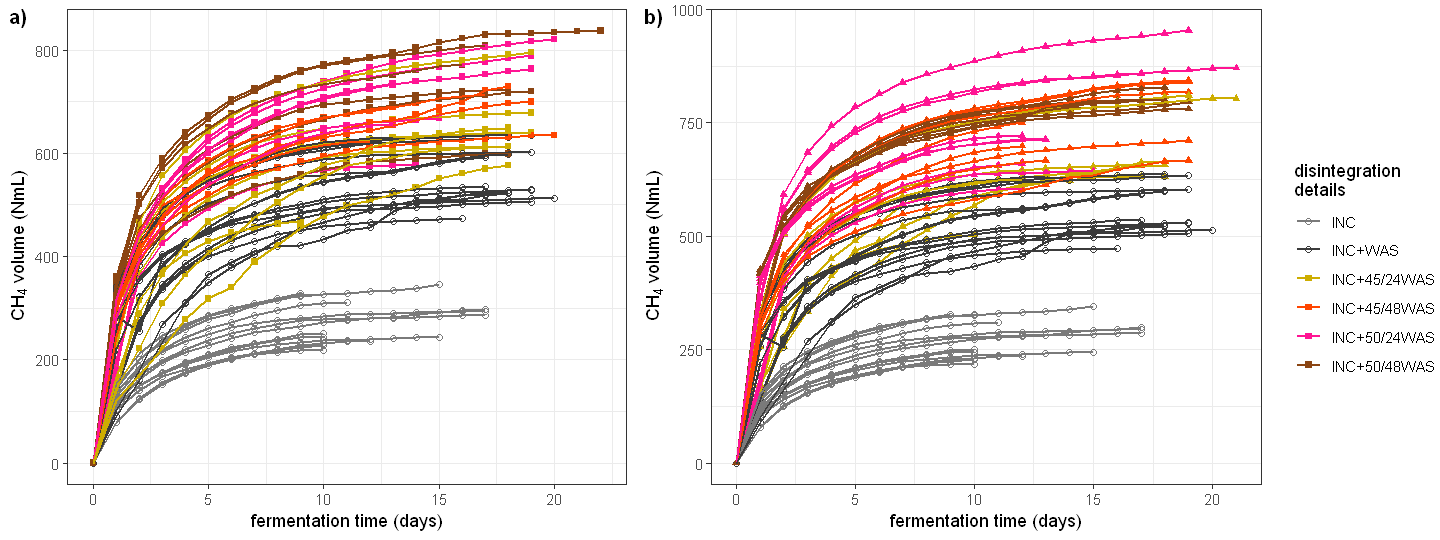

In [9]:
options(repr.plot.width=12, repr.plot.height=4.5)
a <- c('INC','INC+WAS', 'INC+45/24WAS', 'INC+50/24WAS', 'INC+55/24WAS','INC+60/24WAS')
b <- c('INC','INC+WAS', 'INC+45/48WAS', 'INC+50/48WAS','INC+55/48WAS', 'INC+60/48WAS')

tmp.plot1 <- ggplot(df.fer[!is.na(match(df.fer$sample,a)),],
             aes(x=day,y=volume,color=sample.type,shape=sample.type,group=case.exp)) + 
             geom_point() +geom_path(linewidth=0.6) +  
             scale_color_manual(name = "disintegration\ndetails", labels = fact.new, values = sample.colors) + 
             scale_shape_manual(name = "disintegration\ndetails", labels = fact.new, values=sample.symbols) +
             xlab("fermentation time (days)") + ylab(TeX("CH$_4$ volume (NmL)"))
         
tmp.plot2 <- ggplot(df.fer[!is.na(match(df.fer$sample,b)),],
             aes(x=day,y=volume,color=sample.type,shape=sample.type,group=case.exp)) + 
             geom_point() +geom_path(linewidth=0.6) +  
             scale_color_manual(name = "disintegration\ndetails", labels = fact.new, values = sample.colors) + 
             scale_shape_manual(name = "disintegration\ndetails", labels = fact.new, values=sample.symbols) +
             xlab("fermentation time (days)") + ylab(TeX("CH$_4$ volume (NmL)"))

legend <- get_legend(
  # create some space to the left of the legend
  tmp.plot1 + theme(legend.box.margin = margin(0, 0, 0, 13)) 
)

plot.row <- plot_grid(tmp.plot1+theme(legend.position = 'none'), tmp.plot2+theme(legend.position = 'none'),
                labels = c('a)', 'b)'), label_size = 12)

pg <- plot_grid(plot.row,legend,rel_widths = c(3, .4), label_size = 12)

pg


#### 2.2. Plot displaying the same information as in previous plot, but the samples processed differently are displayed saparately

In [10]:
legend <- get_legend( # legend for plot2
  ggplot(df.fer[!is.na(match(df.fer$sample,a)),],
             aes(x=day,y=volume,color=sample.type,shape=sample.type,group=case.exp)) + 
             geom_point() +geom_path(linewidth=0.6) +  
             scale_color_manual(name = "disintegration\ndetails", labels = fact.new, values = sample.colors) + 
             scale_shape_manual(name = "disintegration\ndetails", labels = fact.new, values=sample.symbols)  + 
             theme(legend.box.margin = margin(5, 0, 0, 0),legend.position = 'top') 
)

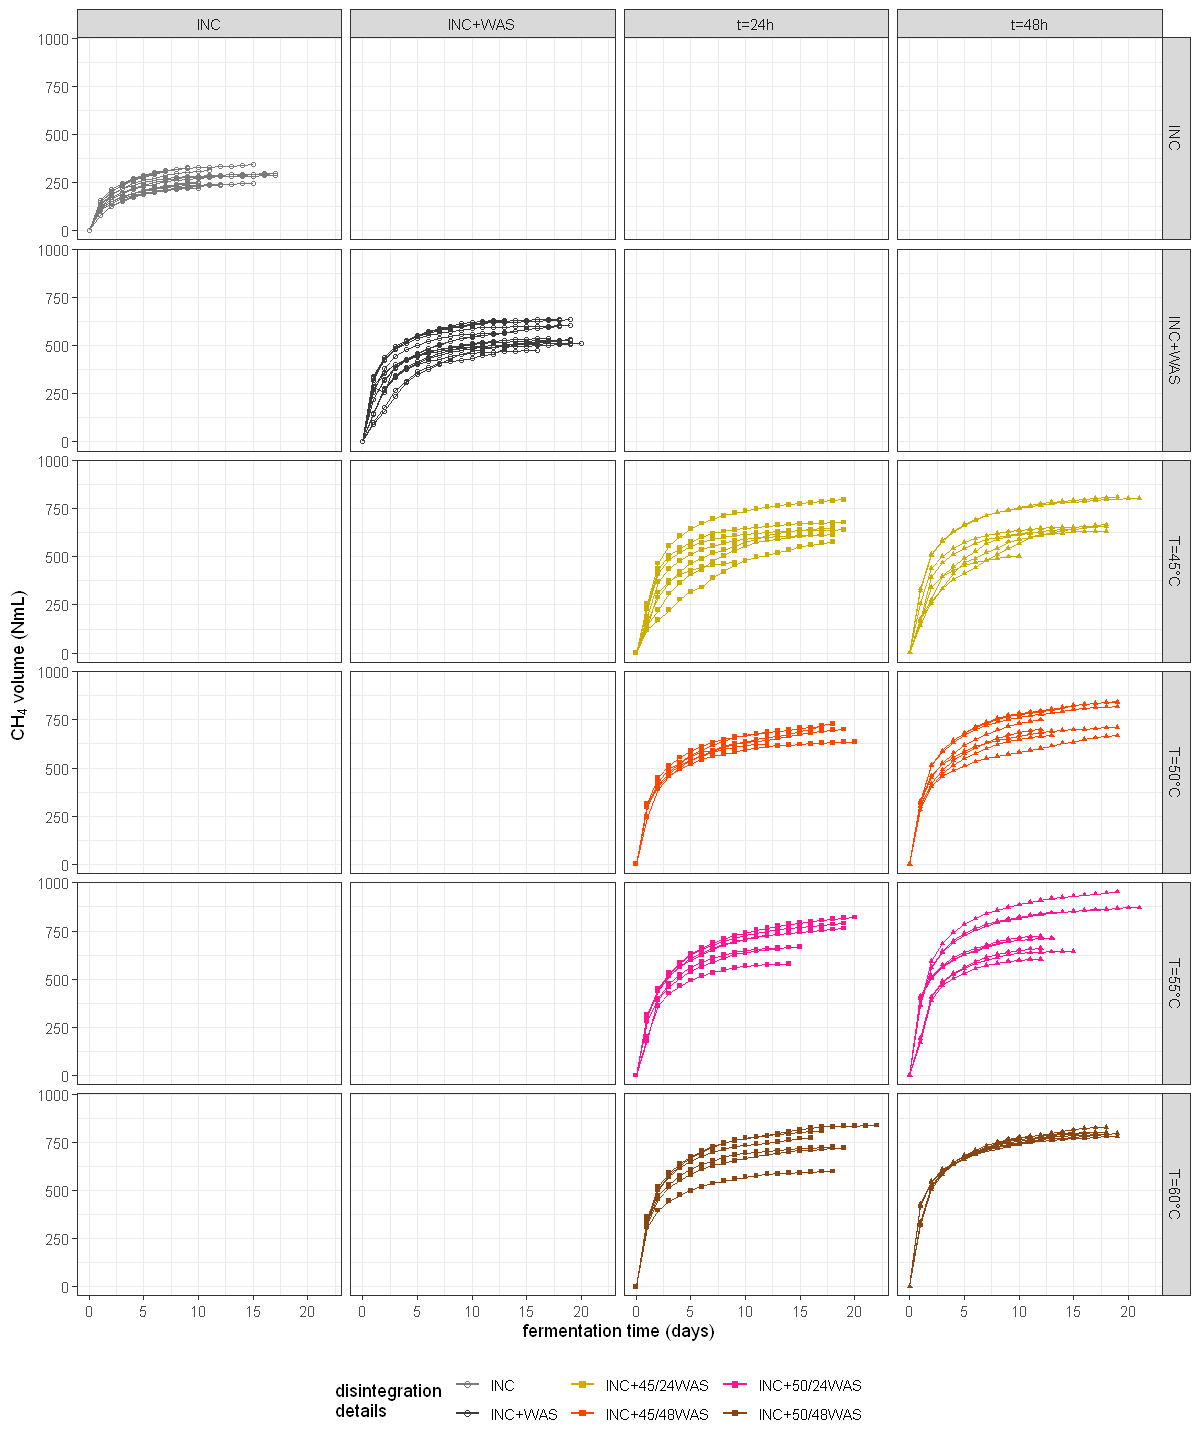

In [11]:
options(repr.plot.width=10, repr.plot.height=12)
tmp.plot <- ggplot(df.fer,aes(x=day,y=volume,color=dis.temp.new,shape=dis.time.new,group=case.exp)) + 
     geom_point(size=1) +geom_path(linewidth=0.5) +  
     scale_color_manual(values=temp.new.colors, name = "disintegration temperature (oC)") + 
     scale_shape_manual(values=time.new.shapes,name="disintegration time (h)") + 
     facet_grid(dis.temp.new~dis.time.new) + theme(legend.position="none") + 
     xlab("fermentation time (days)") + ylab(TeX("CH$_4$ volume (NmL)"))


plot_grid(tmp.plot,legend,rel_heights = c(3, .2),ncol=1, label_size = 12)
#ggsave("IMG/paper/rev2/supplement1.tiff",dpi=opt.dpi, width = 10, height = 12,compression = "lzw")

#### 2.3. Displaying $CH_4$ volume at different fermentation times: 5, 10, 15 days and the end of the fermentation process
This plot presents the boxplots for grouped experimental series types

In [12]:
# Creating auxiliary data frame tmp.df1
tmp.df1 <- df.fer[c('day','volume','case','experiment','case.exp','dis.temp.new','dis.time.new')]

# choosing the rows for the end of the experiment for each experimental series
tmp.df2 <-   tmp.df1 %>%
              select(day, case,experiment,dis.time.new,dis.temp.new,volume) %>%
              group_by(case,experiment) %>%
              filter(day == max(day))

tmp.df2$fact.days <- "end of fermentation process"

days <- c(5,10,15)
tmp.df1 <- tmp.df1[!is.na(match(tmp.df1$day,days)),]
tmp.df1$fact.days <- paste0("fermentation time ",as.character(tmp.df1$day)," days")
tmp.df1$fact.days <- factor(paste0("fermentation time ",as.character(tmp.df1$day)," days"),ordered=TRUE,
                           levels=c("fermentation time 5 days","fermentation time 10 days",
                                    "fermentation time 15 days","end of fermentation process"))

bind.feat <- c('day','volume','dis.temp.new','dis.time.new','fact.days')
tmp.df1 <- rbind(tmp.df1[bind.feat],tmp.df2[bind.feat])

tmp.df2 <- NULL

head(tmp.df1)

,day,volume,dis.temp.new,dis.time.new,fact.days
,<dbl>,<dbl>,<ord>,<ord>,<ord>
6,5,285.3,INC,INC,fermentation time 5 days
11,10,326.5,INC,INC,fermentation time 10 days
16,15,345.3,INC,INC,fermentation time 15 days
22,5,204.6,INC,INC,fermentation time 5 days
27,10,236.6,INC,INC,fermentation time 10 days
32,15,244.1,INC,INC,fermentation time 15 days


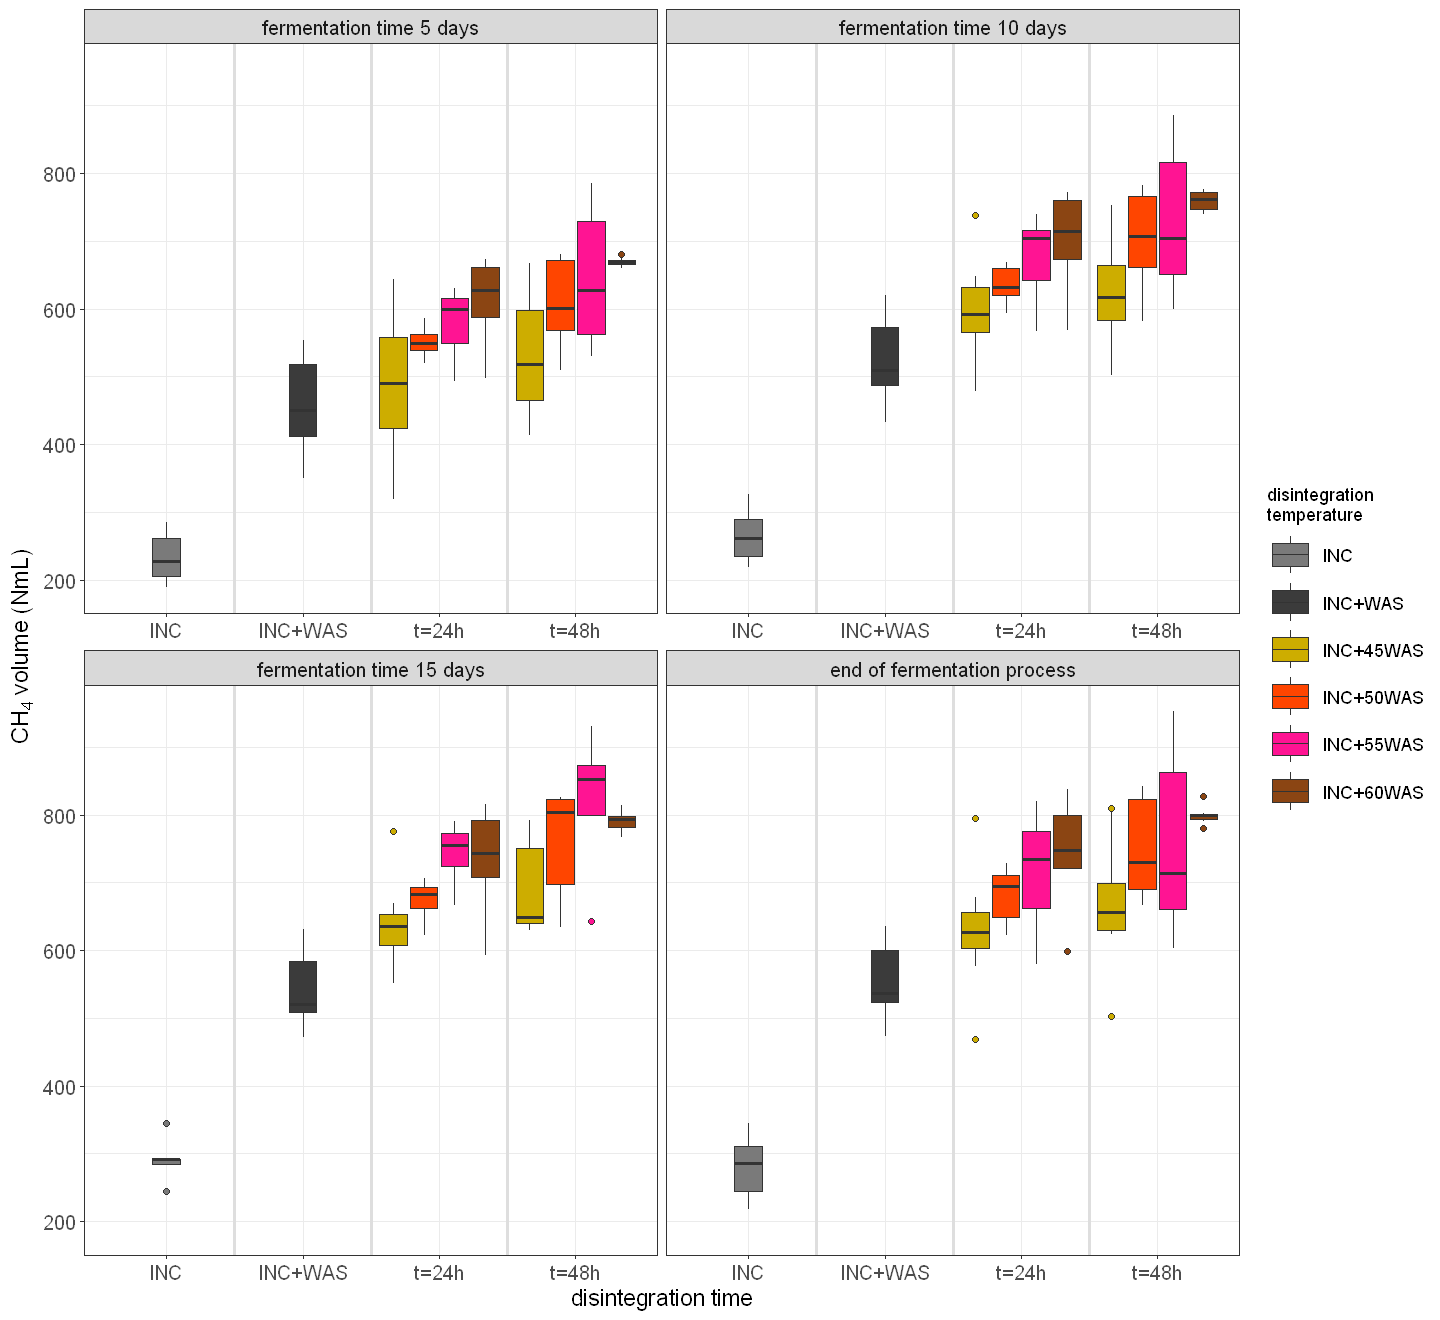

In [13]:
options(repr.plot.height = 11, repr.plot.width = 12)

fer.plot <- ggplot(tmp.df1,aes(x=dis.time.new,y=volume,fill=dis.temp.new)) + 
            geom_boxplot(width=0.9, outlier.shape=21,position = position_dodge2(preserve = "single")) + 
            facet_wrap(.~fact.days,nrow = 2,ncol=2,scales = 'free_x') +
            scale_fill_manual(values = temp.new.colors,labels = c("INC","INC+WAS","INC+45WAS","INC+50WAS","INC+55WAS","INC+60WAS")) +
            xlab("disintegration time") + ylab(TeX("CH$_4$ volume (NmL)")) +
            guides(fill=guide_legend(title="disintegration\ntemperature")) +

            theme(strip.text.x =element_text(size=12),axis.title=element_text(size=14),
                  legend.key.size = unit(1, 'cm'), legend.text = element_text(size=11),
                  axis.text.x = element_text(size=12), axis.text.y = element_text(size=12)) +
            geom_vline(xintercept=seq(1.5, length(unique(tmp.df1$dis.time.new))-0.5, 1),lwd=1, colour="gray87")
fer.plot

#ggsave(plot=fer.plot,"IMG/paper/rev2/fermentation_time.tiff",dpi=opt.dpi, width = 12, height = 11,compression = "lzw")

#### 2.4. Displaying mean $CH_4$ volumes obtained for different pretreatment conditions

`summarise()` has grouped output by 'dis.time.new', 'dis.temp.new'. You can
override using the `.groups` argument.


dis.time.new,dis.temp.new,case,mean.volume
<ord>,<ord>,<dbl>,<dbl>
INC,INC,1,321.9000
INC,INC,7,247.3500
INC,INC,18,231.3500
INC,INC,24,266.5000
INC,INC,30,295.8667
INC+WAS,INC+WAS,2,597.0500


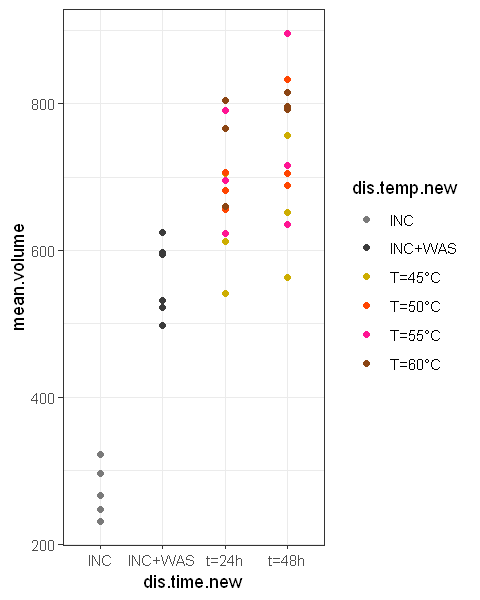

In [14]:
df.fer.end.mean <- df.fer %>%
              select(day, volume, case,experiment,dis.time.new,dis.temp.new) %>%
                 group_by(case,experiment) %>%
                    filter(day == max(day)) %>% 
                      ungroup() %>% 
                        group_by(dis.time.new,dis.temp.new,case) %>% 
                            summarise(mean.volume=mean(volume))

head(df.fer.end.mean)

options(repr.plot.height=5,repr.plot.width=4)
ggplot(df.fer.end.mean) + geom_point(aes(x=dis.time.new,y=mean.volume,color=dis.temp.new))+
scale_color_manual(values = temp.new.colors)

#### 2.5. Process efficiency analysis

##### 2.5.1. Creating a dataframe with spline interpolations of methane production and its derivative

In [15]:
case.exp.levels <- levels(df.fer$case.exp)
tmp.df3 <- NULL
for (ix in 1:length(case.exp.levels))
{
    tmp.df <- df.fer[df.fer$case.exp == case.exp.levels[ix],]
    if (nrow(tmp.df)==0) {
        next
    }  
    
    
    if (length(unique(tmp.df$sample.type))==1){
        sample.type <- unique(tmp.df$sample.type)[1]
    } else {
        print(unique(tmp.df$sample.type))
        stop("too many levels in a dataframe")
    }
    
    splF <- splinefun(tmp.df$day,tmp.df$volume,method = "natural")
    xp <- seq(0,max(tmp.df$day),0.1)
    yp <- splF(xp)    
    h <- 10^-6
    dF <- (splF(xp+h) - splF(xp-h))/(2.0*h) # derivative - symmetyric difference
    
    tmp.df <- data.frame(x=xp,y=yp,dy=dF)
    tmp.df$case.exp <- case.exp.levels[ix]
    tmp.df$sample.type <- sample.type
    
    if (is.null(tmp.df3)){
        tmp.df3 <- tmp.df
    } else {
        tmp.df3 <- rbind(tmp.df3,tmp.df)
    }
}

head(tmp.df3)

,x,y,dy,case.exp,sample.type
,<dbl>,<dbl>,<dbl>,<chr>,<ord>
1,0.0,0.00000,166.6913,1-1,INC
2,0.1,16.64684,166.0225,1-1,INC
3,0.2,33.15992,164.0163,1-1,INC
4,0.3,49.40552,160.6726,1-1,INC
5,0.4,65.24987,155.9915,1-1,INC
6,0.5,80.55922,149.9728,1-1,INC


##### 2.5.2. Plot of the derivatives, with 5 and 10 days marked
This plot was made to see if generally the process performance is similar in different groups

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


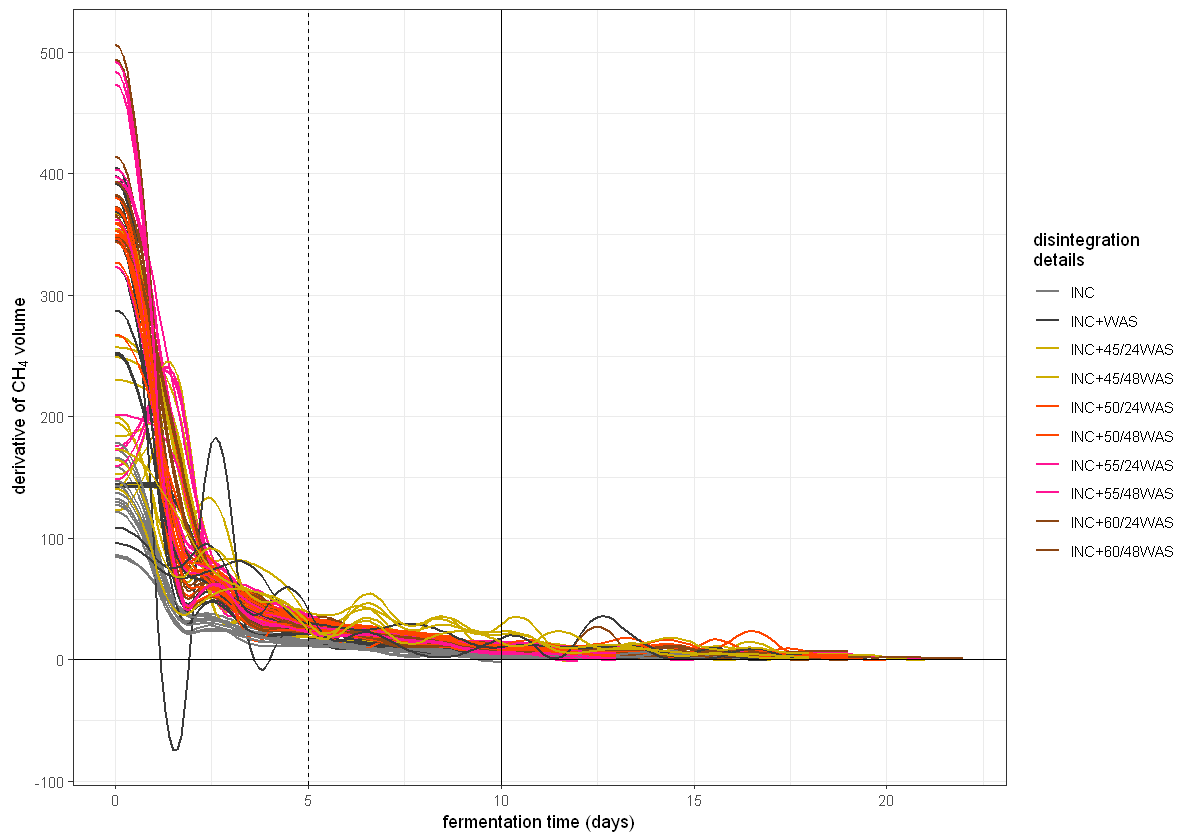

In [16]:
options(repr.plot.width=10, repr.plot.height=7)

ggplot(tmp.df3,
             aes(x=x,y=dy,color=sample.type,shape=sample.type,group=case.exp)) + 
             geom_path(size=0.6) +  
             scale_color_manual(name = "disintegration\ndetails", labels = fact.new, values = sample.colors) + 
             scale_shape_manual(name = "disintegration\ndetails", labels = fact.new, values=sample.symbols) +
             xlab("fermentation time (days)") + ylab(TeX("derivative of CH$_4$ volume")) +
             geom_vline(xintercept=c(5,10),linetype=c("dashed","solid")) + geom_hline(yintercept = 0)

#ggsave("IMG/paper/rev2/DerivativeCH4.tiff",dpi=opt.dpi, width = 8, height = 4.5,compression = "lzw")

##### 2.5.3. Finding the maximum volumes of the $CH_4$

In [17]:
# auxiliary data frame
tmp.df4 <- df.fer %>% 
                group_by(case.exp) %>% 
                   reframe(day,rel.volume=volume/max(volume),sample.type,volume)

In [18]:
tmp.df4 %>% 
    group_by(sample.type,case.exp) %>% 
        summarise(max(volume)) %>% head()

`summarise()` has grouped output by 'sample.type'. You can override using the
`.groups` argument.


sample.type,case.exp,max(volume)
<ord>,<fct>,<dbl>
INC,1-1,327.8
INC,1-2,326.9
INC,1-3,311.0
INC,18-1,227.5
INC,18-2,235.2
INC,24-1,294.6


##### 2.5.4. Finding the time after which 90% of the methane yield was reached
The methane volume was nterpolated using splines, and the Newton method was used to solve for the day at which 90% of volume occurred.

In [19]:
case.exp.levels <- levels(tmp.df4$case.exp)
df.90 <- NULL
for (ix in 1:length(case.exp.levels))
{
    tmp.df <- tmp.df4[tmp.df4$case.exp == case.exp.levels[ix],]
    if (nrow(tmp.df)==0) {
        next
    }  
    
    
    if (length(unique(tmp.df$sample.type))==1){
        sample.type <- unique(tmp.df$sample.type)[1]
    } else {
        print(unique(tmp.df$sample.type))
        stop("too many levels in a dataframe")
    }
    
    splF <- splinefun(tmp.df$day,tmp.df$rel.volume,method = "natural")
    splF1 <- splinefun(tmp.df$day,tmp.df$volume,method = "natural")
    h <- 10^-6
    p = 0.9
    
    #the Newton method
    epsX = 0.001
    x1 <- 9
    x0 <- x1+10*epsX
    while (abs(x1-x0) > epsX){
        x0 <- x1
        x1 <- x0 - (splF(x0)-p)/( ((splF(x0+h)-p)-(splF(x0-h)-p))/(2*h) )
    }
    
    tmp.df <- data.frame(day0.9=round(x1,1),volume=round(splF1(x1),1))
    tmp.df$case.exp <- case.exp.levels[ix]
    tmp.df$sample.type <- sample.type
    
    if (is.null(df.90)){
        df.90 <- tmp.df
    } else {
        df.90 <- rbind(df.90,tmp.df)
    }
}

head(df.90)

,day0.9,volume,case.exp,sample.type
,<dbl>,<dbl>,<chr>,<ord>
1,5.9,295.0,1-1,INC
2,6.3,294.2,1-2,INC
3,6.5,279.9,1-3,INC
4,10.2,591.0,10-1,INC+45/48WAS
5,10.0,568.7,10-2,INC+45/48WAS
6,8.6,598.8,10-3,INC+45/48WAS


##### 2.5.5. Displaying time of reaching 90% of total $CH_4$ volume for each sample type in the form of a boxplot

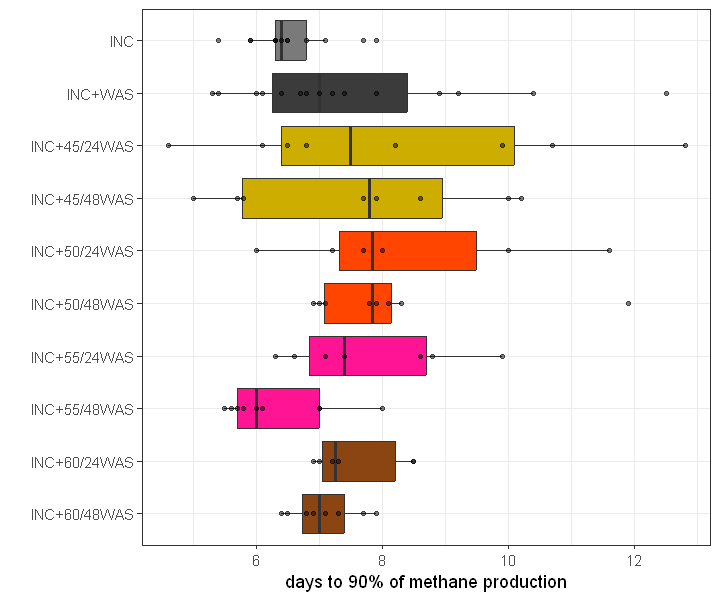

In [20]:
options(repr.plot.width=6,repr.plot.height=5)
ggplot(df.90,aes(x=day0.9,y=sample.type,fill=sample.type)) + geom_boxplot(outlier.alpha=0.0)+ 
geom_point(size=1,alpha=0.5)+
scale_color_manual(name = "disintegration\ndetails", labels = fact.new, values = sample.colors) + 
scale_fill_manual(name = "disintegration\ndetails", labels = fact.new, values = sample.colors) + 
theme(legend.position='none') + xlab("days to 90% of methane production") + ylab("") + scale_y_discrete(limits=rev)

##### 2.5.6. Summary table

In [21]:
df.90 %>% group_by(sample.type)  %>% summarise(median(day0.9),mean(day0.9),min(day0.9),max(day0.9),
                                                  median(volume),mean(volume),min(volume),max(volume)) %>% head()

sample.type,median(day0.9),mean(day0.9),min(day0.9),max(day0.9),median(volume),mean(volume),min(volume),max(volume)
<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INC,6.40,6.538462,5.4,7.9,257.80,249.9308,196.6,310.8
INC+WAS,7.00,7.546667,5.3,12.5,482.50,503.3733,426.5,572.3
INC+45/24WAS,7.50,8.200000,4.6,12.8,564.35,566.4500,421.7,716.1
INC+45/48WAS,7.80,7.612500,5.0,10.2,590.65,601.8750,452.3,728.7
INC+50/24WAS,7.85,8.416667,6.0,11.6,625.60,613.5000,559.8,656.0
INC+50/48WAS,7.85,8.125000,6.9,11.9,657.40,674.3500,600.2,758.5
